# QUESTION 1

The file NormanMinT.csv contains daily minimum temperatures (in F) for Norman, Oklahoma
from July 1, 2002 until February 29, 2020. The goal of this exercise is to make you think about how
and what techniques to use that could make sense for ultimately producing a predictive model for
minimum temperatures in Norman. I am leaving this question fairly open-ended. That means that
you make the choices on how to proceed and justify those choices to me. The one caveat is that
you may use ONLY the data in the file provided for this exercise to complete the task.

Think about concepts we discussed in class, including autoregressive modeling, covariance modeling,
trends, and least-squares fiting. In designing your model, think about any relevant statistics
(e.g., AIC, BIC, (auto-)correlation, etc.) to back up choices you make. Produce the necessary plots
to show your logic. Some guidelines and tips:

* Make sure to take a look at your data before jumping into the modeling. Are there trends you need to consider? What should you do about that?
* You might find some interesting (conflicting?) results between different statistics, so don;t just rely on one statistic!
* Temperatures have a long-term mean and a seasonal cycle. Leaving the seasonal cycle is probably OK (your predictive model should capture this, but if you want to justify removing the seasonal cycle, then do so). However, remember that AR models require centered data (i.e., the overall mean removed).
* You may or may not consider adding "white noise" to your predictive model when doing the reconstruction and predictions.
* For building the predictive model, split the dataset into a "training" and "testing" dataset. That is, you will use your training dataset to build the statistics and the actual statistical model you think works best. Then, you will use data from the test dataset to "test" how well your model performs for 7-day forecasts of minimum temperatures. You might consider including relevant error statistics for sample forecast.
* Fore this exercise, use 2002-2018 as your "training" dataset
* For the forecasting element of the exercise (i.e., "testing"), I want you to make four 7-day forecasts. The start dates will be (a) April 10, 2019, (b) July 10, 2019, (c) October 10, 2019, and (d) January 10, 2020. For example, starting on January 10, 2020, you will use your model to forecast the minimum temperatures for each day from January 11-17, 2020. Remember, these forecasts are for actual temperatures, not anomalies or standardized anomalies.

In the writeup for this problem, include (at least) the following:
* A succinct description (i.e., the equation/defination of terms) of your statistical model (e.g., if your model has 100 terms, please don;t print out all those terms!)
* The reasoning behind how you chose your model, including relevant statistics and/or plots.
* A plot of the original data and the “reconstructed” minimum temperatures from your model overlaid on top from 2002-2018. Include the $r^2$ value of your model on the plot.
* A comparison of your predicted values with the actual values for those seven days, as given in the file. Include any plots and relevant statistics to illustrate your model’s performance and error for each of the forecast periods.
* A discussion of the potential sources of error in your model and whether or not your model could be generalized to work for any period of time (e.g., all seasons, El Niño years, “extreme” periods (warm or cold), etc.).


In [40]:
#import all the libs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels
from statsmodels.tsa.seasonal import STL
import sys
from scipy import stats
import scipy
from scipy.stats import pearsonr
sys.path.append('/Users/allen/Documents/Python/PlotGallary')
from matplotlibconfig import basic
#configure plot
basic()
import warnings
warnings.simplefilter('ignore')

## Data Exploration Analysis (DEA)

In [41]:
temp= pd.read_csv('NormanTMin.csv')
#clean up the data and rearange it
temp.drop(columns='Unnamed: 0', inplace=True)
temp['index']= [pd.to_datetime('%04d-%02d-%02d'%(temp.YEAR[i], temp.MONTH[i], temp.DAY[i]), format='%Y-%m-%d')
                for i in range(len(temp))]
temp.set_index('index', inplace=True)
temp.rename(columns= {'TMIN (F)': 'tmin'}, inplace=True)
print('data has %d rows, ranging from %s to %s'%(len(temp), temp.index[0].strftime('%Y%m%d'),
                                                 temp.index[-1].strftime('%Y%m%d')))
temp.head()

data has 6453 rows, ranging from 20020701 to 20200229


,YEAR,MONTH,DAY,STID,tmin
index,,,,,
2002-07-01,2002,7,1,NRMN,67.39
2002-07-02,2002,7,2,NRMN,70.68
2002-07-03,2002,7,3,NRMN,68.13
2002-07-04,2002,7,4,NRMN,68.13
2002-07-05,2002,7,5,NRMN,72.09


In [42]:
def detrend(y):
    '''
    linear regression to detrend
    
    Args:
    -------------------
    :y - numpy.ndarray; target to detrend
    
    Returns:
    -------------------
    :detrend - numpy.ndarray; 
    '''
    
    t= np.arange(len(y))
    E= np.ones((t.size,2))*np.nan
    E[:,0] = t
    E[:,1] = 1
    xhat = np.linalg.inv(np.transpose(E).dot(E)).dot(E.T).dot(y)
    trend = E.dot(xhat)
    detrend= y- trend
    
    return detrend, xhat, trend

def corr(x,y, t, p=None):
    '''
    Compute t-lag correlation coefficient (1-dimension)
    
    Args:
    -----------------------
    :x - numpy.ndarray; sample 1
    :y - numpy.ndarray; sample 2
    :t - int; t lag
    :p - int; percentile of confidence level for the correlation
    
    Returns:
    -------------------
    :r - float; correlation coefficient
    :t - float; t-score for computing significance
    :r_sig - float; correlation coefficient within p confidence interval
    '''
    assert len(x)==len(y), 'sample should have the same length,\
                            but got %d for sample 1 and %d for sample 2'%(len(x), len(y))
    size= len(x)
    if t<0:
        _x= x[:size-abs(t)]
        _y= y[abs(t):]
    else:
        _x= x[t:]
        _y= y[: size-t]
    
    #compute effective sample sizes Source: Bretherton et al., 1999
    s_x = np.nanstd(_x)
    s_y = np.nanstd(_y) 
    r= np.dot(_x[:,None].T, _y[:, None])/float(size-1)/s_x/s_y
    r1= np.dot(_x[:-1,None].T,_x[1:,None])/float(size-1)/s_x/s_x
    r2= np.dot(_y[:-1, None].T,_y[1:, None])/float(size-1)/s_y/s_y
    Neff= size*(1-r1*r2)/(1+r1*r2)
    
    t= r*(np.sqrt(Neff-2))/(1-r**2)**.5
    
    if p:
        #compute r within confidence interval
        z=1/2*np.log((1+r)/(1-r)) #Fischer's z-transform to unskew data distribution
        z_score= stats.norm.ppf((1+p)/2) # assume normal distribution
        mu_pos= z+z_score*(1/np.sqrt(size-3))
        mu_neg= z-z_score*(1/np.sqrt(size-3))

        upperBounds= (np.exp(2*mu_pos)-1)/(np.exp(2*mu_pos)+1)
        lowerBounds= (np.exp(2*mu_neg)-1)/(np.exp(2*mu_neg)+1)
        
    
    return r, t, upperBounds, lowerBounds

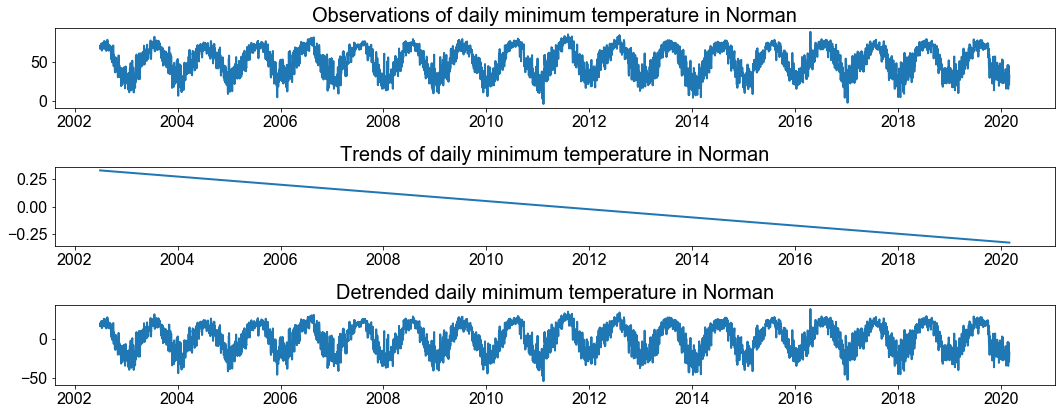

In [43]:
# use yearly averaged daily temperature as climatology to calculate anomalies
temp['doy']= temp.index.dayofyear
# cli= temp.groupby('doy').mean().tmin
# temp['ano']= temp.apply(lambda x: x.tmin-cli.loc[x.doy], axis=1)
temp['ano']= temp.tmin- temp.tmin.mean()

# temp['ano']= temp.tmin - temp.groupby('doy').mean().tmin
temp['detrend'], xhat, trend= detrend(temp['ano'])


fig,ax= plt.subplots(3,1, figsize=(15,6))
ax[0].plot(temp.tmin)
ax[0].set_title('Observations of daily minimum temperature in Norman')
ax[1].plot(temp.index, trend)
ax[1].set_title('Trends of daily minimum temperature in Norman')
ax[2].plot(temp['detrend'])
ax[2].set_title('Detrended daily minimum temperature in Norman');

Fig.1 An overview of daily temperature in Norman with respect to the observation in the upper panel, trend in the middle panel, and detrended in the lower panel.

## Autocorrelation examination

In [135]:
size= len(temp)
results= {
    'lag': [],
    'corr': [],
    't_score': [],
    'upper': [],
    'lower': [],
        }

for t in range(0, 1000, 1):
    # ()
    if t<0:
        _x= temp.ano[:size-abs(t)]
        _y= temp.ano[abs(t):]
    else:
        _x= temp.ano[t:]
        _y= temp.ano[: size-t]
    _corrcoef, _t_score, _upper, _lower= corr(_x, _y, t, .9)
    results['lag'].append(t)
    results['corr'].append(_corrcoef.squeeze())
    results['t_score'].append(_t_score)
    results['upper'].append(_upper.squeeze())
    results['lower'].append(_lower.squeeze())

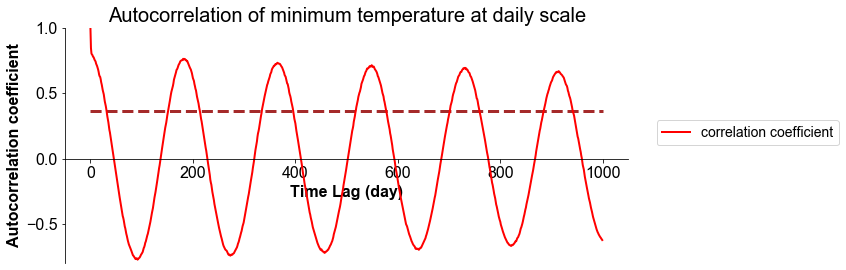

In [45]:
fig, ax= plt.subplots(1,1, figsize=(12,4))
ax.plot([lag for lag in results['lag']], results['corr'], color='r', label='correlation coefficient')
# ax.fill_between([lag//30 for lag in results['lag']], results['upper'], results['lower'], alpha=.5, label='90% confidence interval')

ax.set_xlabel('Time Lag (day)')
ax.set_ylabel('Autocorrelation coefficient')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.vlines(np.array([lag for lag in results['lag']])[np.array(results['corr'])==sorted(results['corr'])[::-1][1]],
#           -.75, 1, linewidth=5, label='highest correlation')
ax.hlines(xmin=0,xmax=1000,y=np.exp(-1),color='brown',linestyle='dashed',\
          linewidth=3)
ax.legend(loc=(1.05,.5))
ax.set_ylim([-.8, 1])
ax.spines['bottom'].set_position(('data', 0))
ax.set_title('Autocorrelation of minimum temperature at daily scale');

Fig.2 Daily autocorrelation of minimum temperature at Norman. The maximum autocorrelation coefficient occurs when time lags/leads 1 day. And the e-folding time scale in this case is 518/885/152/31 day corresponding to (AR518/885/152/31) model.

In [147]:
np.argsort(abs(results['corr']-np.exp(-1)))[:11]

array([518, 885, 152, 941, 759, 577, 396,  31, 942, 213, 335])

## deterministic evaluation

In [161]:
def ARModel(tseries,order=1):
    '''
    AR Model to forecast based on the autocorrelation
    :tseries - numpy array; time series
    :order - int; terms used to forecast
    
    Return:
    -----------------
    :alpha - coefficients
    :yhat - forecast
    '''
    y = tseries[order:]
    x = np.ones((order,y.size))*np.nan
    
    t = tseries.size
    
    for n in range(1,order+1):
        x[n-1,:] = tseries[order-n:t-n]

    Cyx = np.dot(y,x.T)/float(t)
    Cxx = np.dot(x,x.T)/float(t)
    Cxxi = np.linalg.inv(Cxx)
    
    alpha = Cyx.dot(Cxxi)
    yhat = alpha.dot(x)
    
    return alpha,yhat

def AIC(x, kMax):
    '''
    Compute the AIC to determine how many terms to retain
    :x - numpy.array;
    :kMax - maximum terms to test
    
    Return:
    ------------------
    :optK - optimal model terms
    '''
    AIC = np.ones((kMax,))*np.nan
    se2 = np.ones((kMax,))*np.nan
    for k in range(1, kMax+1):
        alpha, yhat= ARModel(x, order=k)
        y= x[k:]
        n= yhat.size
        if k == 1:
            se2[k-1] = ((n-1)/float(n-2))*(1-alpha**2)*np.nanvar(y)
        else:
            se2[k-1] = se2[k-2]*(1-alpha[-1]**2)

        AIC[k-1] = n*np.log( n*se2[k-1]/float(n-k-1) ) + 2*(k+1)

    return AIC, np.where(AIC == AIC.min())[0]+1

def BIC(x, kMax):
    '''
    Compute the BIC to determine how many terms to retain
    :x - numpy.array;
    :kMax - maximum terms to test
    
    Return:
    ------------------
    :optK - optimal model terms
    '''
    BIC = np.ones((kMax,))*np.nan
    se2 = np.ones((kMax,))*np.nan
    for k in range(1, kMax+1):
        alpha, yhat= ARModel(x, order=k)
        y= x[k:]
        n= yhat.size
        if k == 1:
            se2[k-1] = ((n-1)/float(n-2))*(1-alpha**2)*np.nanvar(y)
        else:
            se2[k-1] = se2[k-2]*(1-alpha[-1]**2)

        BIC[k-1] = n*np.log( n*se2[k-1]/float(n-k-1) ) + (k+1)*np.log(n)

    return BIC, np.where(BIC == BIC.min())[0]+1
    


In [165]:
AIC, optTerms_AIC= AIC(temp.tmin, 500)
BIC, optTerms_BIC= BIC(temp.tmin, 500)
print('Optimal terms determined by AIC is: %d'%(optTerms_AIC))
print('Optimal terms determined by BIC is: %d'%(optTerms_BIC))

Optimal terms determined by AIC is: 378
Optimal terms determined by BIC is: 13


__Implication__:

Three different approaches to determine the optimal retaining terms have three different values: AR152 for the autocorrelation result, AR13 for BIC, and AR378 for AIC. These three items are further tested in the validation process to figure out which one to use for forecast.

In the following study, the dataset is not only splitted into training and testing, but also use one validation set to test which one infers the best result and then adopt that term.

## Build AR model

In [177]:
def train_test_split(data):
    # use 2002-2018 as training data and remaining as testing data
    trainidx= (data.YEAR>=2002) & (data.YEAR<=2018)
    testidx= data.YEAR>2018
    
    return data[trainidx], data[testidx]


def forecast(alpha, x, order, year):
    global temp
    y= x[order:]
    ypred= pd.Series(0, index= y.index)
    it= np.where(y.index.year==year)[0][0]
    ypred[:it+1]= y[:it+1]

    for i in range(1, len(y)-it):
        for k in range(1,order+1):
            ypred[i+it]+= ypred[i-k+it]* alpha[k-1]

#             it = np.where( (year==1982) & (month==12))[0][0] #Start the model.

    return ypred[it:]+temp.tmin.mean()

def validation(data):
    '''use 2017 and 2018 as validation period to test AR31 and AR13'''
    train= data[data.index.year!=2017]
    val= data[data.index.year==2017]
    alpha152, yhat152= ARModel(train.ano, order=152)
    alpha378, yhat378= ARModel(train.ano, order=378)
    alpha13, yhat13= ARModel(train.ano, order=13)
    
    acc_score_train_AR378= ACC(yhat378, train.ano[378:])
    rmse_train_AR378= RMSE(yhat378, train.ano[378:])
    
    acc_score_train_AR13= ACC(yhat13, train.ano[13:])
    rmse_train_AR13= RMSE(yhat13, train.ano[13:])    
    
    acc_score_train_AR152= ACC(yhat152, train.ano[152:])
    rmse_train_AR152= RMSE(yhat152, train.ano[152:])   
    
    yrec_AR378= forecast(alpha378, data.ano, 31, 2017) #()
    acc_score_val_AR378= ACC(yrec_AR378, val.ano)
    rmse_val_AR378= RMSE(yrec_AR378, val.ano)
    
    yrec_AR13= forecast(alpha13, data.ano, 13, 2017) #()
    acc_score_val_AR13= ACC(yrec_AR13, val.ano)
    rmse_val_AR13= RMSE(yrec_AR13, val.ano)
    
    yrec_AR152= forecast(alpha152, data.ano, 13, 2017) #()
    acc_score_val_AR152= ACC(yrec_AR152, val.ano)
    rmse_val_AR152= RMSE(yrec_AR152, val.ano)   
    
    results= {'13': [acc_score_train_AR13, acc_score_val_AR13, rmse_train_AR13, rmse_val_AR13],
             '152': [acc_score_train_AR152, acc_score_val_AR152, rmse_train_AR152, rmse_val_AR152],
             '378': [acc_score_train_AR378, acc_score_val_AR378, rmse_train_AR378, rmse_val_AR378]}
    
    return results
            

def ACC(f, v):
    '''
    Anomaly Correlation Coefficient
    
    Args:
    --------------
    :f - forecast anomaly; shape of (time, )
    :v - observed anomaly; shape of (time, )
    
    Reuturns:
    --------------
    :acc_score - shape of (1,)
    '''
    T= f.shape
    acc_score= (f*v).sum()/((f**2).sum()**.5)/((v**2).sum()**.5)
    
    return acc_score

def RMSE(f,v):
    '''
    Root Mean Square Error to quantitatively describe the performance
    
    Args:
    --------------
    :f - forecast anomaly; shape of (time, )
    :v - observed anomaly; shape of (time, )
    
    Reuturns:
    --------------
    :acc_score - shape of (1,)
    '''
    
    return (((f-v)**2).sum()/len(f))**.5

## Model performance examination

In [172]:
train, test= train_test_split(temp)
results= validation(train)

|Model|Data|ACC score|RMSE (F)|
|-----|----|---------|----|
|AR13|training|0.931|6.57|
|AR13|validation|0.193|11.71|
|AR152|training|0.935|6.36|
|AR152|validation|0.306|11.27|
|AR378|training|0.939|6.18|
|AR378|validation|0.338|11.23|

Based on the results, AR378 model has higher score in terms of training and validation, hence it is selected to perform forecast.

In [219]:
ORDER= 378
alpha, yhat= ARModel(train.ano, order=ORDER)
yhat+= temp.tmin.mean()
yrec= forecast(alpha, temp.ano, ORDER, 2019)
print('calibration CC score: %.2f, RMSE: %.2f F,\
    testing CC score is: %.3f, and RMSE: %.3f F'%(pearsonr(yhat, train.tmin[ORDER:])[0], RMSE(yhat, train.tmin[ORDER:]),
                                                   pearsonr(yrec, test.tmin)[0], RMSE(yrec, test.tmin)))

calibration CC score: 0.94, RMSE: 6.17 F,    testing CC score is: 0.890, and RMSE: 8.471 F


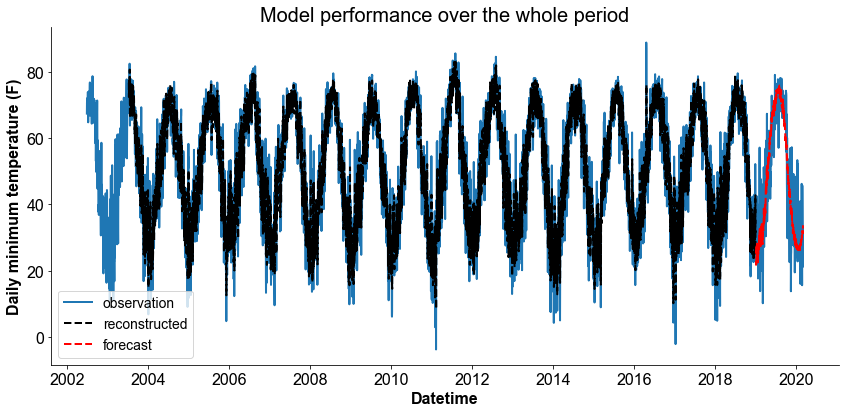

In [220]:
#Plot reconstructed data
fig= plt.figure(figsize=(12,6))
ax= fig.add_subplot()
ax.plot(temp.tmin, label='observation')
ax.plot(train.index[ORDER:], yhat, 'k--', label='reconstructed')
ax.plot(test.index, yrec, 'r--', label='forecast')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
ax.set_ylabel('Daily minimum temperature (F)')
ax.set_xlabel('Datetime')
ax.set_title('Model performance over the whole period');


Fig.3 AR378 model performance. Blue line represents the observation and dashed line depicts reconstruction (black for training and red for forecast).

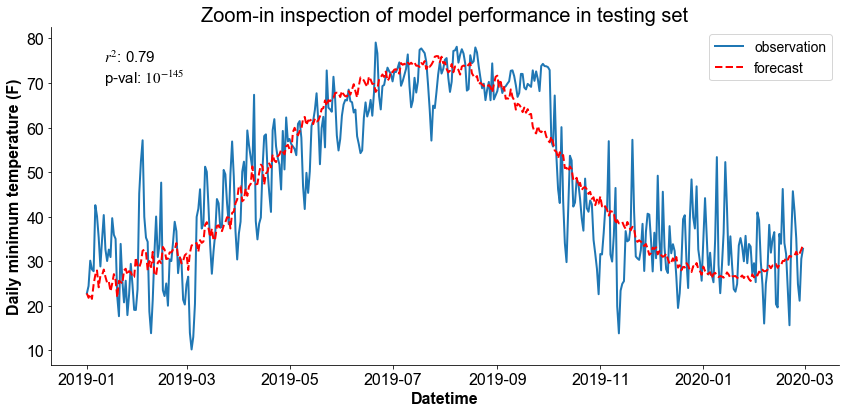

In [224]:
#Plot reconstructed data
fig= plt.figure(figsize=(12,6))
ax= fig.add_subplot()
ax.plot(temp.tmin[test.index], label='observation')
ax.plot(test.index, yrec, 'r--', label='forecast')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
ax.text(test.index[10], 70, '$r^2$: %.2f\np-val: $10^{%d}$'%(pearsonr(yrec, test.tmin)[0]**2,
                                                          np.log10(pearsonr(yrec, test.tmin)[1])))
ax.set_ylabel('Daily minimum temperature (F)')
ax.set_xlabel('Datetime')
ax.set_title('Zoom-in inspection of model performance in testing set');

Fig.4 Zoom-in inspection of AR378 model performance for the forecast period after 2019. Blue line corresponds to observations and red dashed line corresponds to forecast. The corresponding $r^2$ value is 0.79 and p-value is 0.89.

## One-week forecast

Four selected weeks are used to further assess the performance of our model but on daily minimum temperature instead of anomalies. Four chosen dates are: (a) April 10, 2019, (b) July 10, 2019, (c) October 10, 2019, and (d) January 10, 2020.

In [186]:
set1= temp.loc[pd.date_range('20190410', '20190417', freq="D"),:]
set2= temp.loc[pd.date_range('20190710', '20190717', freq="D"),:]
set3= temp.loc[pd.date_range('20191010', '20191017', freq="D"),:]
set4= temp.loc[pd.date_range('20200110', '20200117', freq="D"),:]
yrec1= yrec.loc[pd.date_range('20190410', '20190417', freq="D")]
yrec2= yrec.loc[pd.date_range('20190710', '20190717', freq="D")]
yrec3= yrec.loc[pd.date_range('20191010', '20191017', freq="D")]
yrec4= yrec.loc[pd.date_range('20200110', '20200117', freq="D")]

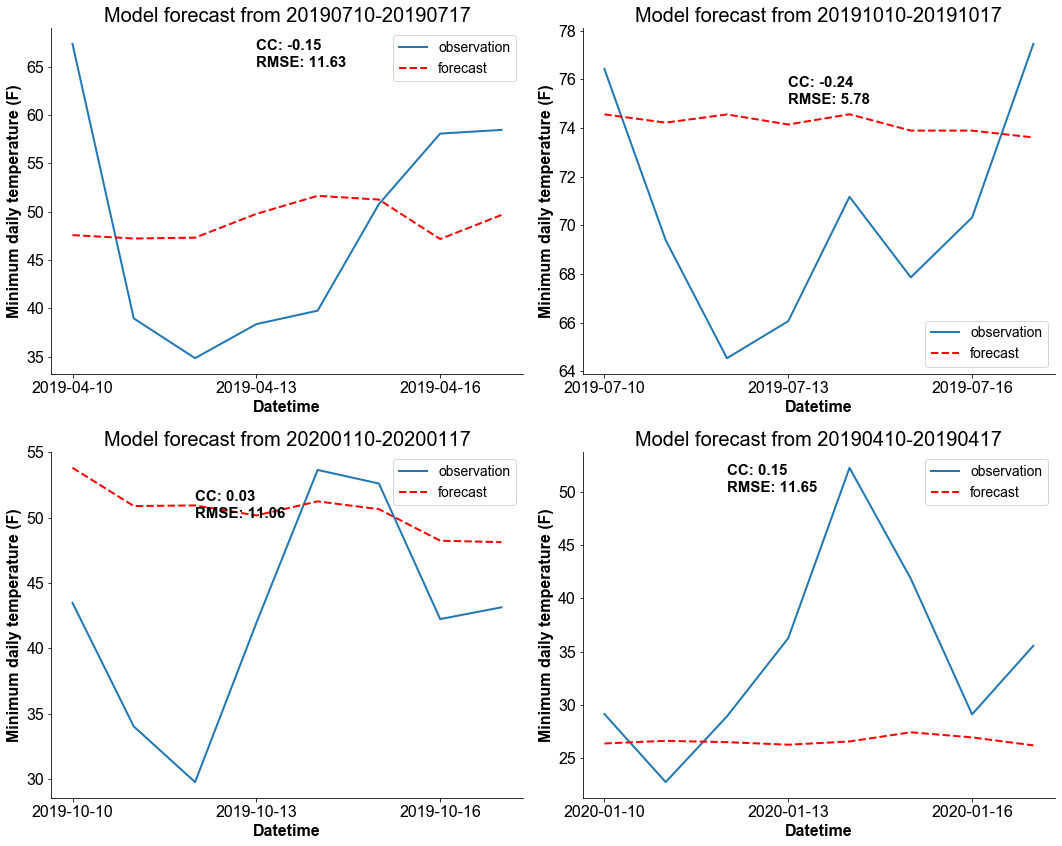

In [187]:
#Plot reconstructed data
fig= plt.figure(figsize=(15,12))
ax= fig.add_subplot(221)
ax.plot(set1.tmin, label='observation')
ax.plot(set1.index, yrec1, 'r--', label='forecast')
ax.text(set1.index[3],65, 'CC: %.2f\nRMSE: %.2f'%(pearsonr(yrec1, set1.tmin)[0], RMSE(yrec1, set1.tmin)),
        weight='bold', fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
ax.set_ylabel('Minimum daily temperature (F)')
ax.set_xlabel('Datetime')
ax.set_title('Model forecast from 20190710-20190717');
ax.set_xticks(set1.index[0:7:3]);
ax= fig.add_subplot(222)
ax.plot(set2.tmin, label='observation')
ax.plot(set2.index, yrec2, 'r--', label='forecast')
ax.text(set2.index[3],75, 'CC: %.2f\nRMSE: %.2f'%(pearsonr(yrec2, set2.tmin)[0], RMSE(yrec2, set2.tmin)),
        weight='bold', fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
ax.set_ylabel('Minimum daily temperature (F)')
ax.set_xlabel('Datetime')
ax.set_title('Model forecast from 20191010-20191017');
ax.set_xticks(set2.index[0:7:3]);
ax= fig.add_subplot(223)
ax.plot(set3.tmin, label='observation')
ax.plot(set3.index, yrec3, 'r--', label='forecast')
ax.text(set3.index[2],50, 'CC: %.2f\nRMSE: %.2f'%(pearsonr(yrec3, set3.tmin)[0], RMSE(yrec3, set3.tmin)),
        weight='bold', fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
ax.set_ylabel('Minimum daily temperature (F)')
ax.set_xlabel('Datetime')
ax.set_title('Model forecast from 20200110-20200117');
ax.set_xticks(set3.index[0:7:3]);
ax= fig.add_subplot(224)
ax.plot(set4.tmin, label='observation')
ax.plot(set4.index, yrec4, 'r--', label='forecast')
ax.text(set4.index[2],50, 'CC: %.2f\nRMSE: %.2f'%(pearsonr(yrec4, set4.tmin)[0], RMSE(yrec4, set4.tmin)),
        weight='bold', fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
ax.set_ylabel('Minimum daily temperature (F)')
ax.set_xlabel('Datetime')
ax.set_title('Model forecast from 20190410-20190417')
ax.set_xticks(set4.index[0:7:3]);

Fig.5 Four-week forecast result using AR378 model.

## Significance testing

The next question regarding to this context is that: is the difference between hindcast and observation significant?

To do that, it is important to choose the appropriate schemes. In model fitting field, normally F-test is used to determine the variance between prediction and target, especially in the time series analysis. Thus, we will use F-statistics to test the variance against hypothesis.

Hypothesis:

$H_0$: there is no difference of variance between forecast and observation.

$H_a$: there is a difference.

In [190]:
fscore= np.nanvar(yrec, axis=0)/np.nanvar(test.tmin, axis=0)
pval= scipy.stats.f.cdf(fscore, len(yrec)-1, len(test.tmin)-1)

if pval<.05: #95% confidence level
    print('Reject the null hypothesis.')
else:
    print('The null hypothesis is valid.')

The null hypothesis is valid.


## How to further improve the forecast skill?

Strategy 1: Adding white noise to the model;

Strategy 2: Remove seasonal cycle (justification)

### White noise

In [215]:
def ARModelNoise(tseries,order=1):
    '''
    AR Model to forecast based on the autocorrelation
    :tseries - numpy array; time series
    :order - int; terms used to forecast
    
    Return:
    -----------------
    :alpha - coefficients
    :yhat - forecast
    '''
    y = tseries[order:]
    x = np.ones((order+1,y.size))*np.nan
    
    t = tseries.size
    
    for n in range(1,order+1):
        x[n-1,:] = tseries[order-n:t-n]
        x[-1,:]= np.random.normal(0,1)

    Cyx = np.dot(y,x.T)/float(t)
    Cxx = np.dot(x,x.T)/float(t)
    Cxxi = np.linalg.inv(Cxx)
    
    alpha = Cyx.dot(Cxxi)
    yhat = alpha.dot(x)
    
    return alpha,yhat


def reconstructNoise(alpha, x, order, year):
    global temp
    y= x[order:]
    ypred= pd.Series(0, index= y.index)
    it= np.where(y.index.year==year)[0][0]
    ypred[:it+1]= y[:it+1]

    for i in range(1, len(y)-it):
        for k in range(1,order+1):
            ypred[i+it]+= ypred[i-k+it]* alpha[k-1]
        ypred[i]+= alpha[-1]*np.random.normal(0,1)

    return ypred[it:]+temp.tmin.mean()

In [216]:
alpha, yhat= ARModelNoise(train.ano, order=ORDER)
yhat+= temp.tmin.mean()
yrec= reconstructNoise(alpha, temp.ano, ORDER, 2019)
print('calibration ACC score: %.2f, RMSE: %.2f F,\
    testing ACC score is: %.3f, and RMSE: %.3f F'%(pearsonr(yhat, train.tmin[ORDER:])[0], RMSE(yhat, train.tmin[ORDER:]),
                                                   pearsonr(yrec, test.tmin)[0], RMSE(yrec, test.tmin)))

calibration ACC score: 0.94, RMSE: 6.17 F,    testing ACC score is: 0.890, and RMSE: 8.471 F


In [217]:
yrec1= yrec.loc[pd.date_range('20190410', '20190417', freq="D")]
yrec2= yrec.loc[pd.date_range('20190710', '20190717', freq="D")]
yrec3= yrec.loc[pd.date_range('20191010', '20191017', freq="D")]
yrec4= yrec.loc[pd.date_range('20200110', '20200117', freq="D")]

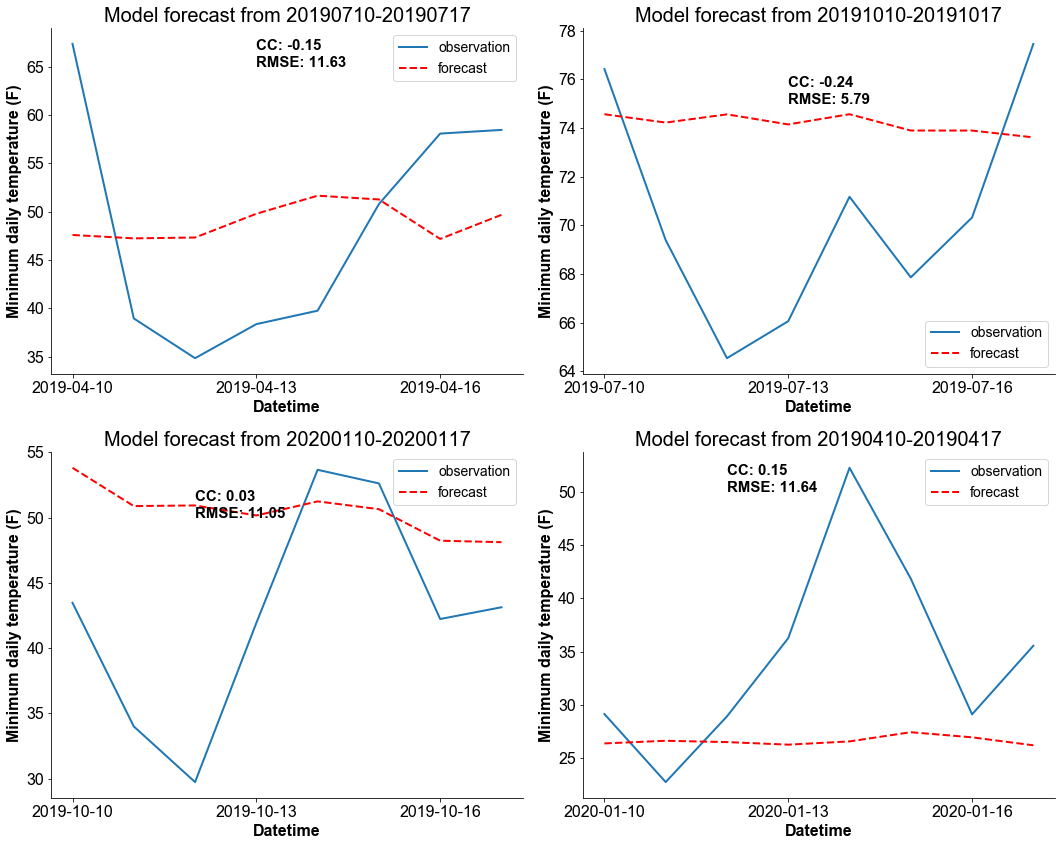

In [218]:
#Plot reconstructed data
fig= plt.figure(figsize=(15,12))
ax= fig.add_subplot(221)
ax.plot(set1.tmin, label='observation')
ax.plot(set1.index, yrec1, 'r--', label='forecast')
ax.text(set1.index[3],65, 'CC: %.2f\nRMSE: %.2f'%(pearsonr(yrec1, set1.tmin)[0], RMSE(yrec1, set1.tmin)),
        weight='bold', fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
ax.set_ylabel('Minimum daily temperature (F)')
ax.set_xlabel('Datetime')
ax.set_title('Model forecast from 20190710-20190717');
ax.set_xticks(set1.index[0:7:3]);
ax= fig.add_subplot(222)
ax.plot(set2.tmin, label='observation')
ax.plot(set2.index, yrec2, 'r--', label='forecast')
ax.text(set2.index[3],75, 'CC: %.2f\nRMSE: %.2f'%(pearsonr(yrec2, set2.tmin)[0], RMSE(yrec2, set2.tmin)),
        weight='bold', fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
ax.set_ylabel('Minimum daily temperature (F)')
ax.set_xlabel('Datetime')
ax.set_title('Model forecast from 20191010-20191017');
ax.set_xticks(set2.index[0:7:3]);
ax= fig.add_subplot(223)
ax.plot(set3.tmin, label='observation')
ax.plot(set3.index, yrec3, 'r--', label='forecast')
ax.text(set3.index[2],50, 'CC: %.2f\nRMSE: %.2f'%(pearsonr(yrec3, set3.tmin)[0], RMSE(yrec3, set3.tmin)),
        weight='bold', fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
ax.set_ylabel('Minimum daily temperature (F)')
ax.set_xlabel('Datetime')
ax.set_title('Model forecast from 20200110-20200117');
ax.set_xticks(set3.index[0:7:3]);
ax= fig.add_subplot(224)
ax.plot(set4.tmin, label='observation')
ax.plot(set4.index, yrec4, 'r--', label='forecast')
ax.text(set4.index[2],50, 'CC: %.2f\nRMSE: %.2f'%(pearsonr(yrec4, set4.tmin)[0], RMSE(yrec4, set4.tmin)),
        weight='bold', fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
ax.set_ylabel('Minimum daily temperature (F)')
ax.set_xlabel('Datetime')
ax.set_title('Model forecast from 20190410-20190417')
ax.set_xticks(set4.index[0:7:3]);

Fig.6  Four-week forecast result using AR378 model (adding white noise).

It is found that the weights added on white noise are really marginal. Hence, it does not make any differences to whether add white noise or not.

### Remove seasonality

In [207]:
def reconstructSeason(alpha, x, order, year):
    global temp
    y= x[order:].rmSeason
    ypred= pd.Series(0, index= y.index)
    it= np.where(y.index.year==year)[0][0]
    ypred[:it+1]= y[:it+1]

    for i in range(1, len(y)-it):
        for k in range(1,order+1):
            ypred[i+it]+= ypred[i-k+it]* alpha[k-1]
            
    for n in range(len(ypred)):
        ypred[n]= ypred[n] + cli.loc[x.iloc[order:,:].doy[n]]
    return ypred[it:]

cli= temp.groupby('doy').mean().tmin
temp['rmSeason']= temp.apply(lambda x: x.tmin-cli.loc[x.doy], axis=1)
train, test= train_test_split(temp)
alpha, yhat= ARModel(train.rmSeason, order=ORDER)

yrec= reconstructSeason(alpha, temp, ORDER, 2019)
print('testing CC score is: %.3f, and RMSE: %.3f F'%(
                                                   pearsonr(yrec, test.tmin)[0], RMSE(yrec, test.tmin)))

testing CC score is: 0.892, and RMSE: 8.229 F


In [208]:
yrec1= yrec.loc[pd.date_range('20190410', '20190417', freq="D")]
yrec2= yrec.loc[pd.date_range('20190710', '20190717', freq="D")]
yrec3= yrec.loc[pd.date_range('20191010', '20191017', freq="D")]
yrec4= yrec.loc[pd.date_range('20200110', '20200117', freq="D")]

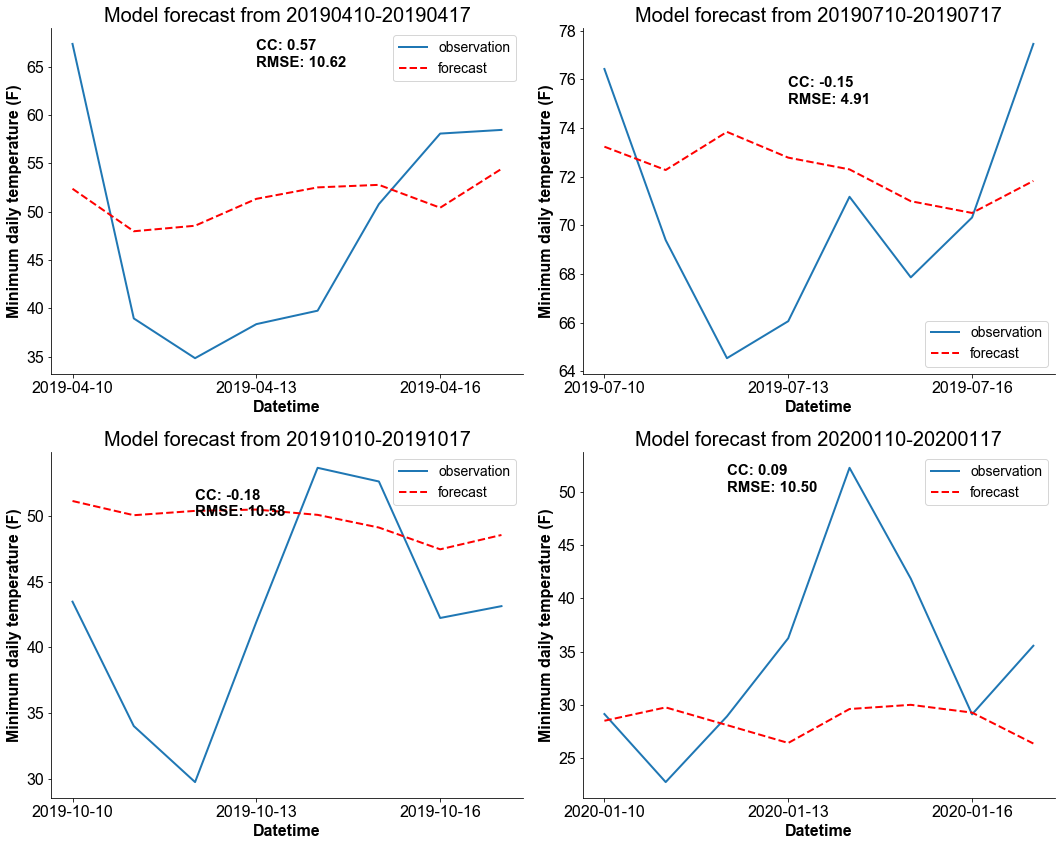

In [209]:
#Plot reconstructed data
fig= plt.figure(figsize=(15,12))
ax= fig.add_subplot(221)
ax.plot(set1.tmin, label='observation')
ax.plot(set1.index, yrec1, 'r--', label='forecast')
ax.text(set1.index[3],65, 'CC: %.2f\nRMSE: %.2f'%(pearsonr(yrec1, set1.tmin)[0], RMSE(yrec1, set1.tmin)),
        weight='bold', fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
ax.set_ylabel('Minimum daily temperature (F)')
ax.set_xlabel('Datetime')
ax.set_title('Model forecast from 20190410-20190417');
ax.set_xticks(set1.index[0:7:3]);
ax= fig.add_subplot(222)
ax.plot(set2.tmin, label='observation')
ax.plot(set2.index, yrec2, 'r--', label='forecast')
ax.text(set2.index[3],75, 'CC: %.2f\nRMSE: %.2f'%(pearsonr(yrec2, set2.tmin)[0], RMSE(yrec2, set2.tmin)),
        weight='bold', fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
ax.set_ylabel('Minimum daily temperature (F)')
ax.set_xlabel('Datetime')
ax.set_title('Model forecast from 20190710-20190717');
ax.set_xticks(set2.index[0:7:3]);
ax= fig.add_subplot(223)
ax.plot(set3.tmin, label='observation')
ax.plot(set3.index, yrec3, 'r--', label='forecast')
ax.text(set3.index[2],50, 'CC: %.2f\nRMSE: %.2f'%(pearsonr(yrec3, set3.tmin)[0], RMSE(yrec3, set3.tmin)),
        weight='bold', fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
ax.set_ylabel('Minimum daily temperature (F)')
ax.set_xlabel('Datetime')
ax.set_title('Model forecast from 20191010-20191017');
ax.set_xticks(set3.index[0:7:3]);
ax= fig.add_subplot(224)
ax.plot(set4.tmin, label='observation')
ax.plot(set4.index, yrec4, 'r--', label='forecast')
ax.text(set4.index[2],50, 'CC: %.2f\nRMSE: %.2f'%(pearsonr(yrec4, set4.tmin)[0], RMSE(yrec4, set4.tmin)),
        weight='bold', fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
ax.set_ylabel('Minimum daily temperature (F)')
ax.set_xlabel('Datetime')
ax.set_title('Model forecast from 20200110-20200117')
ax.set_xticks(set4.index[0:7:3]);

Fig.7 Four-week forecast result using AR378 model (removed seasonality).

## Summary write-up

__Summary:__

Selecting an optimal AR model is challenging. In this study, the number of terms is determined based on three approaches: (1) inspection of auto-correlation function; (2) deterministic evaluation based on AIC/BIC. Three AR models are then built based on different results: AR13 (BIC), AR152 (auto-correlation), and AR378 (AIC). In order to further choose the possibly best one out of the three, the dataset is not only evaluated with training (2002-2017) and testing (2019-), but also split into validation period (2017-2018) for model selection. 


It is found that AR378 could generate best results both in training period and validation period, and it is thus retained to perform forecast. The r2 for testing period is 0.79 and p value is 10-145 under null hypothesis, which indicates the correlation between observation and forecast is not trivial.


For forecast, four-week subset is chosen in Fig.5, but they cannot capture the trend very well, meaning this forecast model still performs poorly in the short-scale period. To further improve the model, two strategies are compared, one with white noise added to the model (Fig.6), and the other one removed seasonality (Fig.7). It is proved that removing seasonality could bring some improvements to the forecast skill while adding white noise does not improve a bit.


Given this context and the possibly best model, it can capture the seasonal variation of the temperature but fail to predict the fine-scale variations especially in short-period (daily scale). Thus, it possibly can be used in large scale forecast (long-term climatological forecast) but is challenging to well predict extreme situations or El Nino years. The sources of error are variant. From the model side, the linear combination of all past possible days is not able to describe the complex and dynamic system. Furthermore, one limitation is the data. Without enough data to fit in an optimal model, it is hard to reasonably generate good results.